### Initializations

Import 3rd party modules

In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as scint
import pathlib

Import the fertilization module

In [2]:
from fertilization import *

Set the output directory (adapt as needed).

In [3]:
base_dir = pathlib.Path(".").resolve()

Make sure that figures are generated with editable texts

In [4]:
old_fonttype = plt.rcParams['svg.fonttype']

In [5]:
plt.rcParams['svg.fonttype'] = 'none'

## Time variation in % motile

Egg parameters: diameter = 120μm [note that _cross sectional_ area $A_\times = \pi r^2 = \pi (D/2)^2$], initial concentration = 50 eggs/mL, probability of fertilization given hit (fertilizability) = 0.1 

In [6]:
sigma0 = np.array([
    np.pi * (0.5 * 120E-6)**2,
])
alpha_const = np.array([[0.1]])
Einit = np.array([50E6])

Create the fertilizability function from the constant value

In [7]:
def a_egg(t):
    return alpha_const

Fertilization time = 1 hour = 60 minutes = 3600 seconds

In [8]:
t_end = 60 * 60
t_array = np.arange(t_end / 4, t_end + 1, t_end / 4)

Unchanged sperm parameters:
- sperm speed at 100 μm/s
- concentration ranges logrithmically from 10 sperms per mL to 10000 sperms per mL

In [9]:
v_const = np.array([100E-6])

def v_sperm(t):
    return v_const

# 10**(2+6) to 10**(5+6)
Sinit_array = np.logspace(1 + 6, 5 + 6, (5 - 1) * 16 + 1, base=10)

"Good" proportion motile: constant at 0.8

In [10]:
SR_gd = 0.8
chi_gd = 0.0

Varying proportion motile: exponential decay from 0.8 to 0.4 over 1 hour

In [11]:
SR_end = 0.4
chi_bd = -np.log(SR_end / SR_gd) / t_end

"Bad" proportion motile: constant value designed so that the average propotion motile over time is the same as the time-varying case.

In [12]:
area_under = scint.quad(lambda t: SR_gd * np.exp(-chi_bd * t), 0, t_end)
SR_avg = area_under[0] / t_end

Print out the values of the above

In [13]:
print(area_under)
print(SR_avg)

(2077.480858880108, 2.3064670827467415e-11)
0.5770780163555855


### Case (a) proportion motile at constant 80%

Initialize the arrays for $S_0$ and $E_*$

In [14]:
S0_S_array_gd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_gd = np.zeros([Sinit_array.size, t_array.size])

Define the sperm decay function for the constant case

In [15]:
def d_sperm_gd(t):
    return np.array([chi_gd])

Loop through sperm concentrations, compute $S_0$ and $E_0$ and populate the arrays

NOTE that `S_init` is the concentration of motile sperm, thus the nominal concentration `_S` is multiplied by `SR_gd`

In [16]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm, d_sperm_gd, np.array([_S * SR_gd]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_gd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_gd[_i, :] = model_S.E_any(t_array)[0]

Calculate proportion of free live sperms and fertilized eggs

In [17]:
norm_S0_S_gd = S0_S_array_gd / Sinit_array[:, np.newaxis]
norm_Eany_S_gd = Eany_S_array_gd / Einit

Plot proportion fertilized as function of sperm concentration

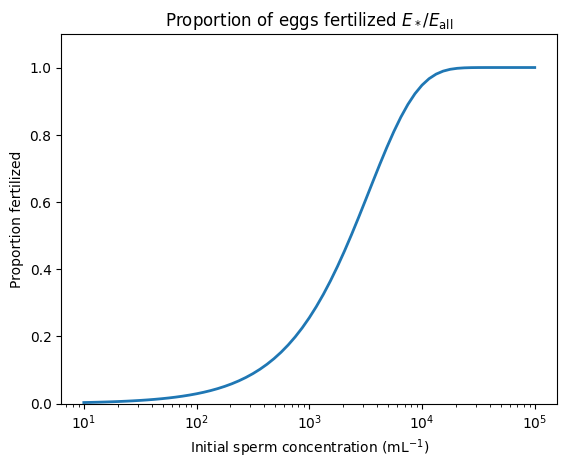

In [18]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")

#plt.savefig(base_dir / 'prop_fert_good.svg')
#plt.savefig(base_dir / 'prop_fert_good.pdf')

plt.show()

Plot the proportion of free live sperm at the end of the fertilization period.

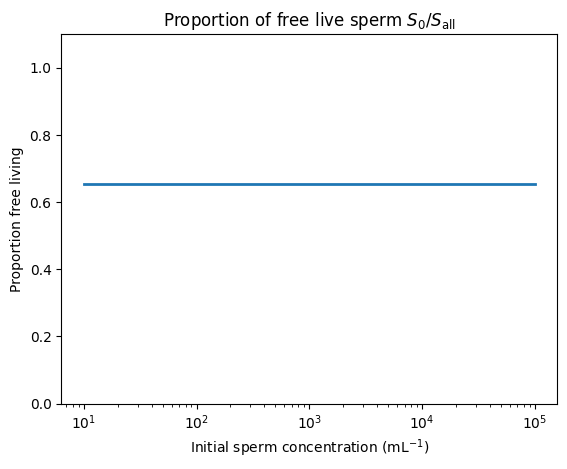

In [19]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_gd[:, -1], lw=2, 
    label="normal"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0,1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")

plt.show()

### Case (b) Constant decay rate, 80% motile @ t = 0, 40% motile @ t = t_end

Initialize arrays, define sperm decay, loop through sperm concentration, etc.

In [20]:
S0_S_array_var = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_var = np.zeros([Sinit_array.size, t_array.size])

In [21]:
def d_sperm_var(t):
    return np.array([chi_bd])

In [22]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm, d_sperm_var, np.array([_S * SR_gd]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_var[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_var[_i, :] = model_S.E_any(t_array)[0]

In [23]:
norm_S0_S_var = S0_S_array_var / Sinit_array[:, np.newaxis]
norm_Eany_S_var = Eany_S_array_var / Einit

Plot proportion fertilized as function of sperm concentration, including both the good and deacying cases.

Save the plot in both `.svg` and `.pdf` formats

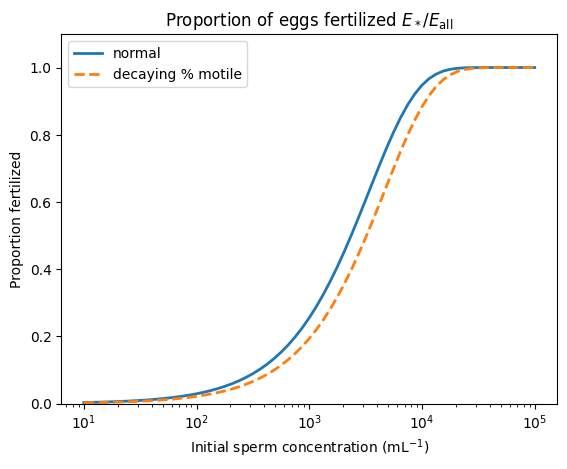

In [24]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_var[:, -1], lw=2, ls="--",
    label="decaying % motile"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.savefig(base_dir / 'prop_fert_var.svg')
plt.savefig(base_dir / 'prop_fert_var.pdf')

plt.show()

Compute the proportion fertilized _relative_ to the normal (const. 80% motile) case

In [25]:
ratio_Eany_S_gd = norm_Eany_S_gd / norm_Eany_S_gd
ratio_Eany_S_var = norm_Eany_S_var / norm_Eany_S_gd

Plot the relative proportion fertilized as function of concentration, and save

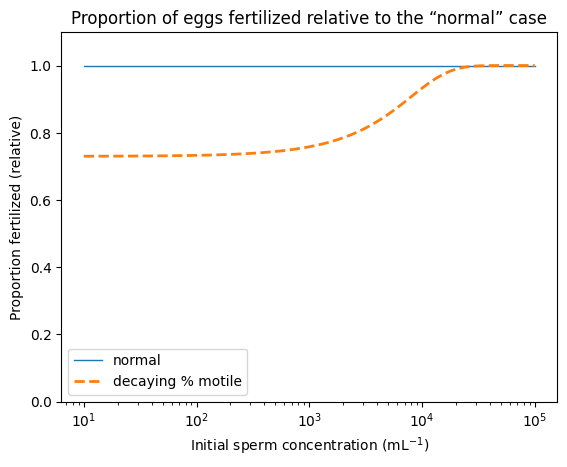

In [26]:
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_gd[:, -1], lw=1, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_var[:, -1], lw=2, ls="--",
    label="decaying % motile"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_fert_var.svg')
plt.savefig(base_dir / 'ratio_fert_var.pdf')

plt.show()

Plot of proportion of free live sperm at the end of the fertilization period (not saved).

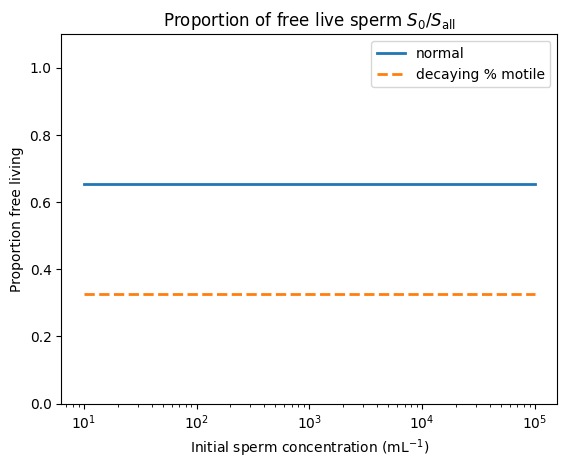

In [27]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_gd[:, -1], lw=2, 
    label="normal"
)

plt.plot(
    1E-6 * Sinit_array, norm_S0_S_var[:, -1], lw=2, ls="--",
    label="decaying % motile"
)

plt.title("Proportion of free live sperm $S_0 / S_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free living")
plt.legend()

plt.show()

### Case (c): Proportion motile at 57.7% ( = average of the decaying case)

In [28]:
S0_S_array_bd = np.zeros([Sinit_array.size, t_array.size])
Eany_S_array_bd = np.zeros([Sinit_array.size, t_array.size])

In [29]:
for _i, _S in enumerate(Sinit_array):
    model_S = FertilizationModel(
        v_sperm, d_sperm_gd, np.array([_S * SR_avg]),
        a_egg, sigma0, Einit,
        t_end
    )
    model_S.solve_S0()
    model_S.solve_pmn()
    S0_S_array_bd[_i, :] = model_S.S0(t_array)[0]
    Eany_S_array_bd[_i, :] = model_S.E_any(t_array)[0]

In [30]:
norm_S0_S_bd = S0_S_array_bd / Sinit_array[:, np.newaxis]
norm_Eany_S_bd = Eany_S_array_bd / Einit

Plot comparing "fast", "slow", and "decreasing speed" cases (saved).

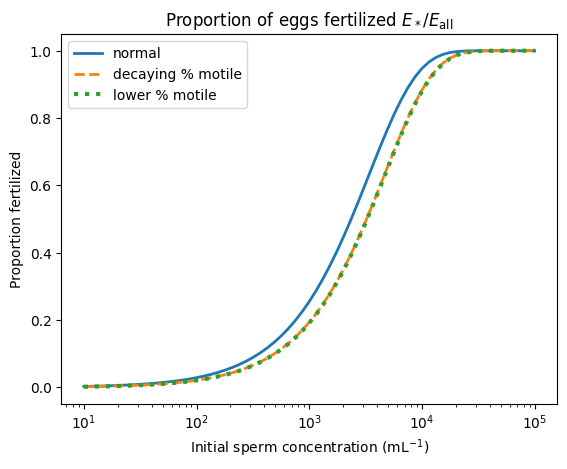

In [31]:
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_var[:, -1], lw=2, ls="--",
    label="decaying % motile"
)
plt.plot(
    1E-6 * Sinit_array, norm_Eany_S_bd[:, -1], lw=3, ls=":",
    label="lower % motile"
)

plt.title("Proportion of eggs fertilized $E_* / E_\\text{all}$")
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized")
plt.legend()

plt.savefig(base_dir / 'prop_fert_bad.pdf')
plt.savefig(base_dir / 'prop_fert_bad.svg')

plt.show()

Compute the proportion fertilized _relative_ to the normal (const. 80% motile) case. Plot and save.

In [32]:
ratio_Eany_S_gd = norm_Eany_S_gd / norm_Eany_S_gd
ratio_Eany_S_bd = norm_Eany_S_bd / norm_Eany_S_gd
ratio_Eany_S_var = norm_Eany_S_var / norm_Eany_S_gd

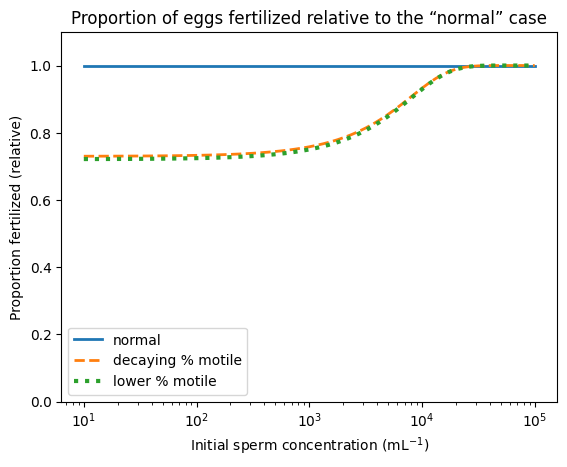

In [33]:
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_gd[:, -1], lw=2, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_var[:, -1], lw=2, ls="--",
    label="decaying % motile"
)
plt.plot(
    1E-6 * Sinit_array, ratio_Eany_S_bd[:, -1], lw=3, ls=":",
    label="lower % motile"
)

plt.title("Proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.savefig(base_dir / 'ratio_fert_bad.svg')
plt.savefig(base_dir / 'ratio_fert_bad.pdf')

plt.show()

Plot the difference between the decaying case and the lower constant cases, relative to the normal (constant 80% motile) case (not saved)

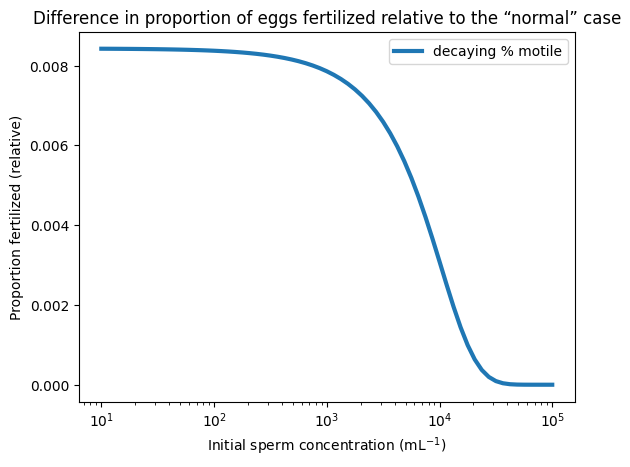

In [34]:
plt.plot(
    1E-6 * Sinit_array, 
    (ratio_Eany_S_var[:, -1] - ratio_Eany_S_bd[:, -1]) / ratio_Eany_S_gd[:, -1], 
    label="decaying % motile", lw=3
)

plt.title("Difference in proportion of eggs fertilized relative to the “normal” case")
plt.xscale("log")
#plt.yscale("log")
#plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion fertilized (relative)")
plt.legend()

plt.show()

Plot portion of free-live sperms for the 3 cases (no save)

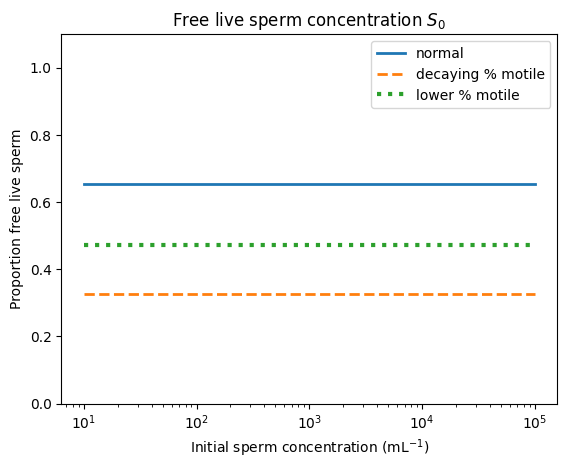

In [35]:
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_gd[:, -1], lw=2, 
    label="normal"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_var[:, -1], lw=2, ls="--", 
    label="decaying % motile"
)
plt.plot(
    1E-6 * Sinit_array, norm_S0_S_bd[:, -1], lw=3, ls=":",
    label="lower % motile"
)

plt.title("Free live sperm concentration $S_0$")
plt.xscale("log")
#plt.yscale("log")
plt.ylim([0, 1.1])
plt.xlabel("Initial sperm concentration (mL$^{-1}$)")
plt.ylabel("Proportion free live sperm")
plt.legend()

plt.show()

## Saving numerical results

Construct the correct sperm concentration and time point labels for serialized numpy arrays

In [36]:
S_grid, t_grid = np.meshgrid(
    Sinit_array, t_array, indexing='ij'
)

Construct dataframes for the proportion fertilized data for the "normal", "lower", and "decaying" cases

In [37]:
df_gd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "E_* prop": norm_Eany_S_gd.ravel(),
})
df_bd = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "E_* prop": norm_Eany_S_bd.ravel(),
})
df_var = pd.DataFrame({
    "time (s)": t_grid.ravel(),
    "Sinit (m^-3)": S_grid.ravel(),
    "E_* prop": norm_Eany_S_var.ravel(),
})

Write to Excel (with each dataframe a separate sheet)

In [38]:
with pd.ExcelWriter('chi_variation.xlsx', mode='w') as writer:  
    df_gd.to_excel(writer, sheet_name='normal', index=False)
    df_bd.to_excel(writer, sheet_name='lower_const', index=False)
    df_var.to_excel(writer, sheet_name='decaying', index=False)

Record the relevant parameters used and save to file

In [39]:
param_str = f'''
sigma0 = {sigma0.item()}
alpha = {alpha_const.item()}
Einit = {Einit.item()}

v_sperm = {v_const.item()}

t_end = {t_end}


d_sperm_gd = {chi_gd}
d_sperm_bd = {chi_bd}

SR_gd = {SR_gd}
SR_end = {SR_end}
SR_bd = {SR_avg}
'''

In [40]:
with open(base_dir / "chi_var_params.txt", "w") as outfile:
    outfile.write(param_str)